# Gradient boosting model

# Notebook set-up

In [1]:
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

## 1. Data loading

In [2]:
with open('../data/processed/sales.pkl', 'rb') as input_file:
    sales_data = pickle.load(input_file)

with open('../data/processed/sales.pkl', 'rb') as input_file:
    turnaround_data = pickle.load(input_file)

## 2. Sales regression

### 2.1. Data inspection

In [3]:
training_df = sales_data['training']
testing_df = sales_data['testing']

training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849 entries, 0 to 6848
Columns: 254 entries, 1 to Sales
dtypes: float64(254)
memory usage: 13.3 MB


In [4]:
training_df.head()

,1,Ship_Mode_First Class,Ship_Mode_Same Day,Ship_Mode_Second Class,Ship_Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Region_Central,Region_East,...,Order_Day_sin Order_Day_cos,Order_Day_sin Order_Month_Sin,Order_Day_sin Order_Month_Cos,Order_Day_cos^2,Order_Day_cos Order_Month_Sin,Order_Day_cos Order_Month_Cos,Order_Month_Sin^2,Order_Month_Sin Order_Month_Cos,Order_Month_Cos^2,Sales
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.487464,-0.677086,-0.390916,0.38874,-0.539958,-0.311745,0.75,0.433013,0.25,447.840
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.487464,0.677086,-0.390916,0.38874,0.539958,-0.311745,0.75,-0.433013,0.25,20.724
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.487464,-0.390916,0.677086,0.38874,-0.311745,0.539958,0.25,-0.433013,0.75,17.940
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-0.487464,0.677086,-0.390916,0.38874,-0.539958,0.311745,0.75,-0.433013,0.25,36.288
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.487464,-0.390916,0.677086,0.38874,-0.311745,0.539958,0.25,-0.433013,0.75,1263.300


In [5]:
training_df.describe()

,1,Ship_Mode_First Class,Ship_Mode_Same Day,Ship_Mode_Second Class,Ship_Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Region_Central,Region_East,...,Order_Day_sin Order_Day_cos,Order_Day_sin Order_Month_Sin,Order_Day_sin Order_Month_Cos,Order_Day_cos^2,Order_Day_cos Order_Month_Sin,Order_Day_cos Order_Month_Cos,Order_Month_Sin^2,Order_Month_Sin Order_Month_Cos,Order_Month_Cos^2,Sales
count,6849.0,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,...,6849.000000,6849.000000,6849.000000,6849.000000,6.849000e+03,6.849000e+03,6.849000e+03,6.849000e+03,6.849000e+03,6849.000000
mean,1.0,0.156373,0.054168,0.193897,0.595561,0.520368,0.298584,0.181048,0.234341,0.280479,...,0.042932,0.019075,-0.011537,0.454089,-3.385536e-02,2.455187e-02,4.775150e-01,-7.156817e-02,5.224850e-01,206.917602
std,0.0,0.363235,0.226366,0.395378,0.490819,0.499621,0.457670,0.385086,0.423617,0.449266,...,0.352054,0.513026,0.531317,0.349489,4.613883e-01,4.894151e-01,3.743983e-01,3.228529e-01,3.743983e-01,423.746238
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.487464,-0.974928,-0.974928,0.049516,-1.000000e+00,-1.000000e+00,1.499760e-32,-4.330127e-01,3.749399e-33,0.556000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.216942,-0.390916,-0.390916,0.049516,-3.117449e-01,-3.117449e-01,2.500000e-01,-4.330127e-01,2.500000e-01,17.460000
50%,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.388740,-2.725095e-17,3.817774e-17,2.500000e-01,-2.449294e-16,7.500000e-01,53.250000
75%,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.390916,0.390916,0.390916,0.811745,2.225209e-01,4.504844e-01,7.500000e-01,1.836970e-16,7.500000e-01,208.160000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.487464,0.974928,0.974928,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,4.330127e-01,1.000000e+00,5443.960000


## 2.2. Linear regression

Training R² = 0.131
Training RMSE = 394.890

Testing R² = 0.084
Testing RMSE = 478.074



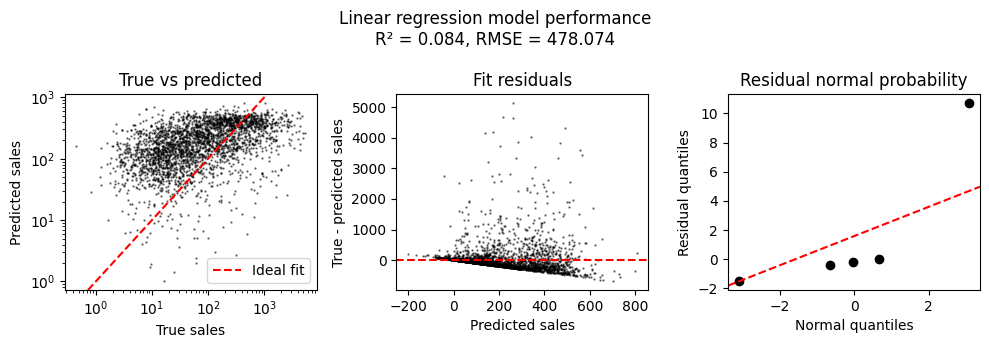

In [6]:
linear_model = LinearRegression()
result = linear_model.fit(training_df.drop('Sales', axis=1), training_df['Sales'])

training_predictions = linear_model.predict(training_df.drop('Sales', axis=1))
training_labels = training_df['Sales']

predictions = linear_model.predict(testing_df.drop('Sales', axis=1))
labels = testing_df['Sales']
residuals = labels - predictions
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
residual_quantiles = np.percentile(standardized_residuals, [0, 25, 50, 75, 100])
normal_quantiles = np.percentile(np.random.normal(size=1000), [0, 25, 50, 75, 100])

training_rsq = r2_score(training_labels, training_predictions)
training_rmse = root_mean_squared_error(training_labels, training_predictions)

print(f'Training R\u00b2 = {training_rsq:.3f}')
print(f'Training RMSE = {training_rmse:.3f}\n')

rsq = r2_score(labels, predictions)
rmse = root_mean_squared_error(labels, predictions)

print(f'Testing R\u00b2 = {rsq:.3f}')
print(f'Testing RMSE = {rmse:.3f}\n')

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))

fig.suptitle(f'Linear regression model performance\nR\u00b2 = {rsq:.3f}, RMSE = {rmse:.3f}')

axs[0].set_title('True vs predicted')
axs[0].scatter(labels, predictions, color='black', s=0.5, alpha=0.5)
axs[0].axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal fit')
axs[0].set_xlabel('True sales')
axs[0].set_ylabel('Predicted sales')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend(loc='best')

axs[1].set_title('Fit residuals')
axs[1].scatter(predictions, residuals, color='black', s=0.5, alpha=0.5)
axs[1].axhline(0, color='red', linestyle='--', label='Ideal fit')
axs[1].set_xlabel('Predicted sales')
axs[1].set_ylabel('True - predicted sales')


axs[2].set_title('Residual normal probability')
axs[2].scatter(normal_quantiles, residual_quantiles, color='black')
axs[2].axline((normal_quantiles[0], residual_quantiles[0]), slope=1, color='red', linestyle='--', label='Ideal fit')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residual quantiles')

fig.tight_layout()
fig.show()

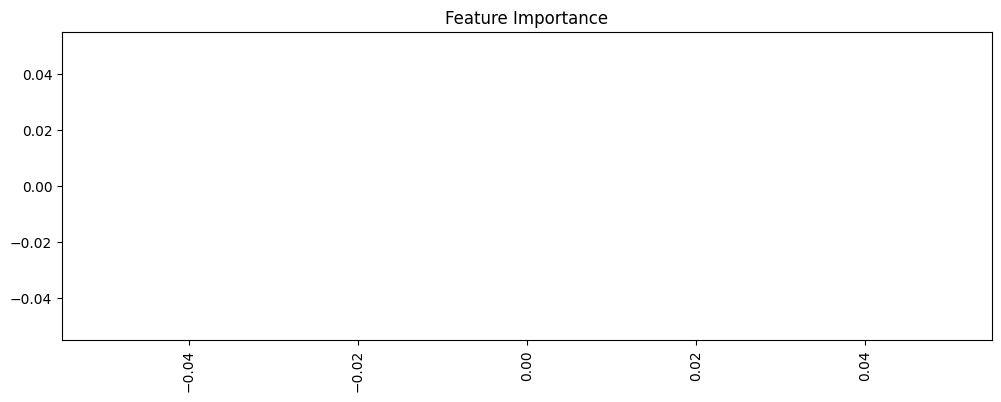

In [7]:
importance = pd.DataFrame({
    'Feature': training_df.drop('Sales', axis=1).columns,
    'Importance': linear_model.coef_
})

importance = importance[(importance['Importance'] > 1000) | (importance['Importance'] < -1000)]

importance.sort_values(by='Importance', inplace=True)

fig, ax = plt.subplots(1,1, figsize=(12,4))

ax.set_title('Feature Importance')
ax.bar(importance['Feature'], importance['Importance'], color='black')
ax.tick_params('x', labelrotation=90)
fig.show()

Training R² = 0.371
Training RMSE = 336.173

Testing R² = 0.193
Testing RMSE = 448.848



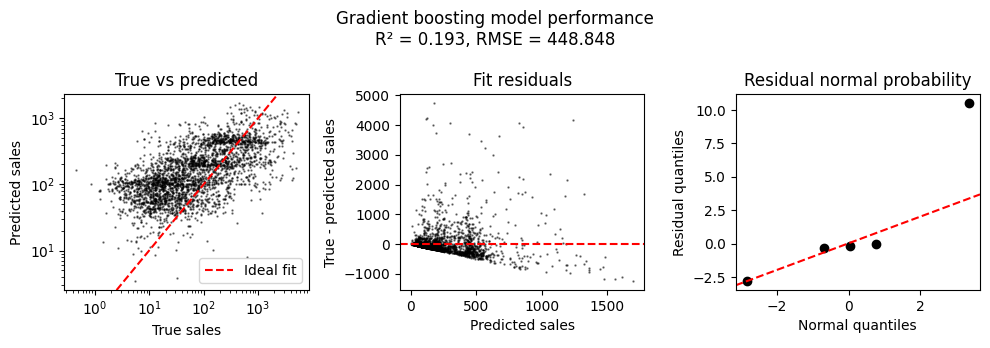

In [8]:
gbt_model = GradientBoostingRegressor()
result = gbt_model.fit(training_df.drop('Sales', axis=1), training_df['Sales'])

training_predictions = gbt_model.predict(training_df.drop('Sales', axis=1))
training_labels = training_df['Sales']

predictions = gbt_model.predict(testing_df.drop('Sales', axis=1))
labels = testing_df['Sales']
residuals = labels - predictions
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
residual_quantiles = np.percentile(standardized_residuals, [0, 25, 50, 75, 100])
normal_quantiles = np.percentile(np.random.normal(size=1000), [0, 25, 50, 75, 100])

training_rsq = r2_score(training_labels, training_predictions)
training_rmse = root_mean_squared_error(training_labels, training_predictions)

print(f'Training R\u00b2 = {training_rsq:.3f}')
print(f'Training RMSE = {training_rmse:.3f}\n')

rsq = r2_score(labels, predictions)
rmse = root_mean_squared_error(labels, predictions)

print(f'Testing R\u00b2 = {rsq:.3f}')
print(f'Testing RMSE = {rmse:.3f}\n')

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))

fig.suptitle(f'Gradient boosting model performance\nR\u00b2 = {rsq:.3f}, RMSE = {rmse:.3f}')

axs[0].set_title('True vs predicted')
axs[0].scatter(labels, predictions, color='black', s=0.5, alpha=0.5)
axs[0].axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal fit')
axs[0].set_xlabel('True sales')
axs[0].set_ylabel('Predicted sales')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend(loc='best')

axs[1].set_title('Fit residuals')
axs[1].scatter(predictions, residuals, color='black', s=0.5, alpha=0.5)
axs[1].axhline(0, color='red', linestyle='--', label='Ideal fit')
axs[1].set_xlabel('Predicted sales')
axs[1].set_ylabel('True - predicted sales')


axs[2].set_title('Residual normal probability')
axs[2].scatter(normal_quantiles, residual_quantiles, color='black')
axs[2].axline((normal_quantiles[0], residual_quantiles[0]), slope=1, color='red', linestyle='--', label='Ideal fit')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residual quantiles')

fig.tight_layout()
fig.show()